In [1]:
from pandas import read_csv, DataFrame
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from matplotlib import pyplot
pyplot.rcParams["figure.figsize"] = (20,10)

In [4]:
csvs = ['../../data_set2/data_age_based.csv',
        '../../data_set2/data_hospital.csv',
           '../../data_set2/data_response_measures.csv',
               '../../data_set2/data_testing.csv',
           '../../data_set2/data_vaccine.csv', 
       '../../data_set2/data_vaccine_map/dataset_vaccine_and_testing.csv']
datasets = []
csv_testing = csvs[3]
data = read_csv(csv_testing, index_col=2, parse_dates=True, squeeze=True)
datasets.append(data)

csv_testing_vaccine = csvs[5]
data = read_csv(csv_testing_vaccine, index_col=0, parse_dates=True, squeeze=True)
datasets.append(data)
# data.plot()
# print(csv)
# print(data.shape)
# pyplot.show()

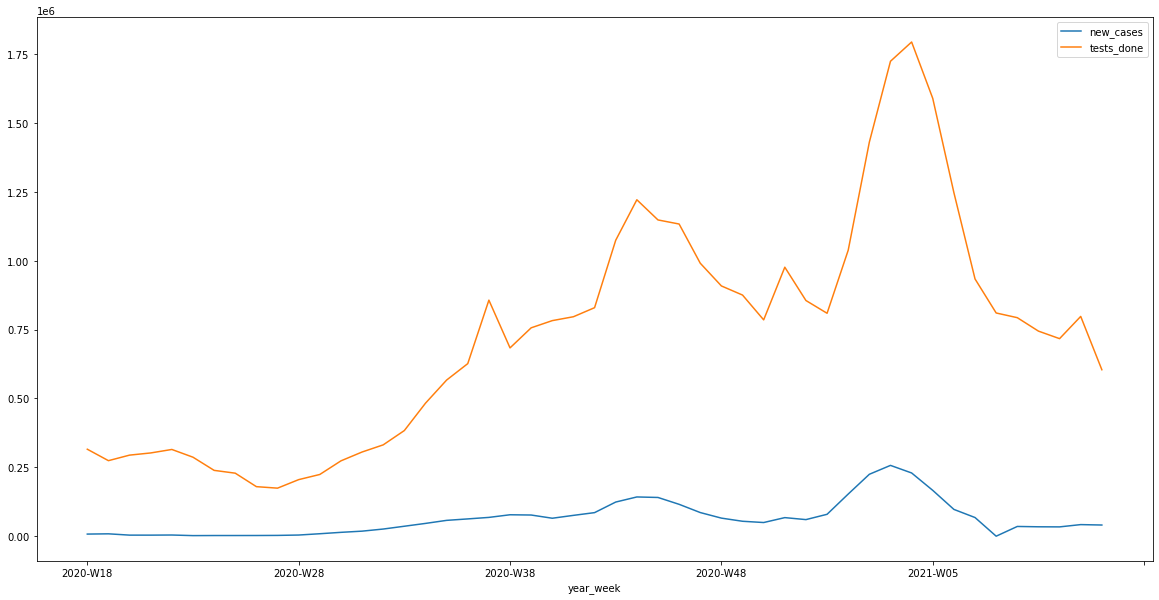

In [12]:
dataset_number = 0
country_code = 'ES'
dataset = datasets[dataset_number]
working_dataset = dataset[dataset['country_code']==country_code].copy().drop('country', axis='columns').drop('country_code', axis='columns').drop('level', axis='columns').drop('region', axis='columns').drop('region_name', axis='columns').drop('population', axis='columns').drop('testing_rate', axis='columns').drop('positivity_rate', axis='columns').drop('testing_data_source', axis='columns')

alg = IsolationForest(random_state=0)
#alg = LocalOutlierFactor(novelty=True, n_neighbors=200)
# alg = LocalOutlierFactor(novelty=False, n_neighbors=200)

# print(working_dataset)
working_dataset.plot()
pyplot.show()

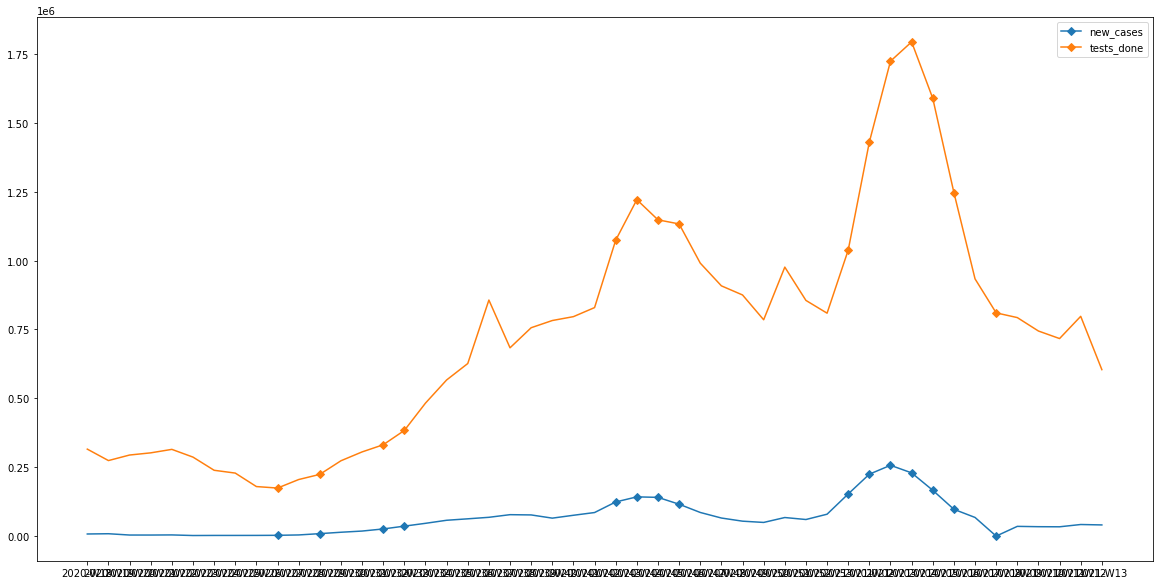

fit on all, predict on all
Number of outliers:
15
Wall time: 743 ms


In [65]:
%%time
#fit on all, predict on all

clf = alg.fit(working_dataset)
pred = clf.predict(working_dataset)
indices = [index for index, element in enumerate(pred) if element == -1]
pyplot.plot(working_dataset, '-D', markevery=indices)
pyplot.legend(['new_cases', 'tests_done'])
pyplot.show()
print("fit on all, predict on all")
print("Number of outliers:")
print(len(indices))

In [16]:
def split_dataframe(df, chunk_size = 100): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunk = df[i*chunk_size:(i+1)*chunk_size]
        if len(chunk) > 0:
            chunks.append(chunk)
    return chunks

def join_dataframe(list_of_datraframes):
    df = DataFrame()
    for dataframe in list_of_datraframes:
        df = df.append(dataframe)
    return df

C:\Users\ioana\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:473: RuntimeWarning: invalid value encountered in true_divide
  -depths
C:\Users\ioana\anaconda3\lib\site-packages\sklearn\ensemble\_iforest.py:336: RuntimeWarning: invalid value encountered in less
  is_inlier[self.decision_function(X) < 0] = -1


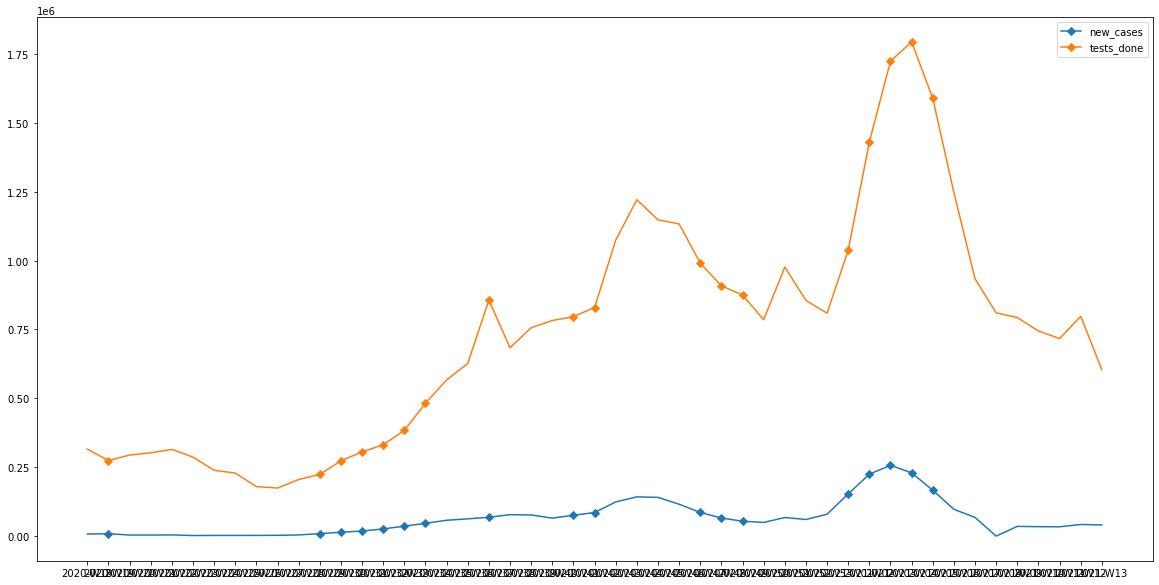

Wall time: 2.03 s


In [67]:
%%time
#fit on half a period, predict on period, period == chunck_size

#split in chuncks of x days
fit_size = 4
chunck_size = fit_size * 2
chuncks = split_dataframe(working_dataset, chunck_size)
pred = []

for chunck in chuncks:
    time_frame = split_dataframe(chunck, fit_size)
    clf = alg.fit(time_frame[0])
    pred.extend(clf.predict(chunck).tolist())
    
# -1 is an anomaly and 1 is ok
indices = [index for index, element in enumerate(pred) if element == -1]
pyplot.plot(working_dataset, '-D', markevery=indices)
pyplot.legend(['new_cases', 'tests_done'])
pyplot.show()

overlapped
total outliers: 34


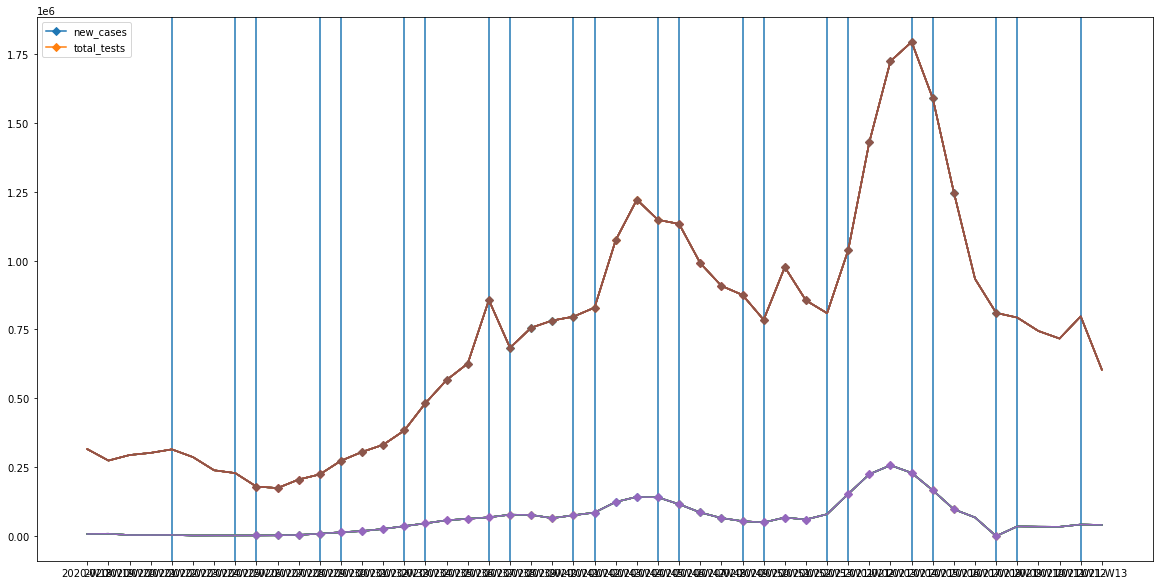

Wall time: 3.17 s


In [68]:
%%time
#fit on past, predict on current month

#split in chuncks of x weeks
chunck_size = 4
chuncks = split_dataframe(working_dataset, chunck_size)
total_indices = []

for index, current in enumerate(chuncks[1:], start=1):
    until_current = join_dataframe(chuncks[:index])
    
    clf = alg.fit(until_current)
    pred = clf.predict(current).tolist()
    indices = [num + index * chunck_size for num, element in enumerate(pred) if element == -1]
    total_indices.extend(indices)
    vertical_marks = []
    pyplot.plot(working_dataset, '-D', markevery=indices)
    try:
        start_incides = index * chunck_size
        end_incides = ( index + 1 ) * chunck_size - 1 
        vertical_marks = [working_dataset.iloc[start_incides].name, working_dataset.iloc[end_incides].name]
        pyplot.axvline(x=vertical_marks[0])
        pyplot.axvline(x=vertical_marks[1])
    except:
        pass
#     pyplot.legend(['new_cases', 'total_tests'])
#     pyplot.show()
    
print("overlapped")
print(f"total outliers: {len(total_indices)}")
pyplot.plot(working_dataset, '-D', markevery=total_indices)
pyplot.legend(['new_cases', 'total_tests'])
pyplot.show()

overlapped
total outliers: 30


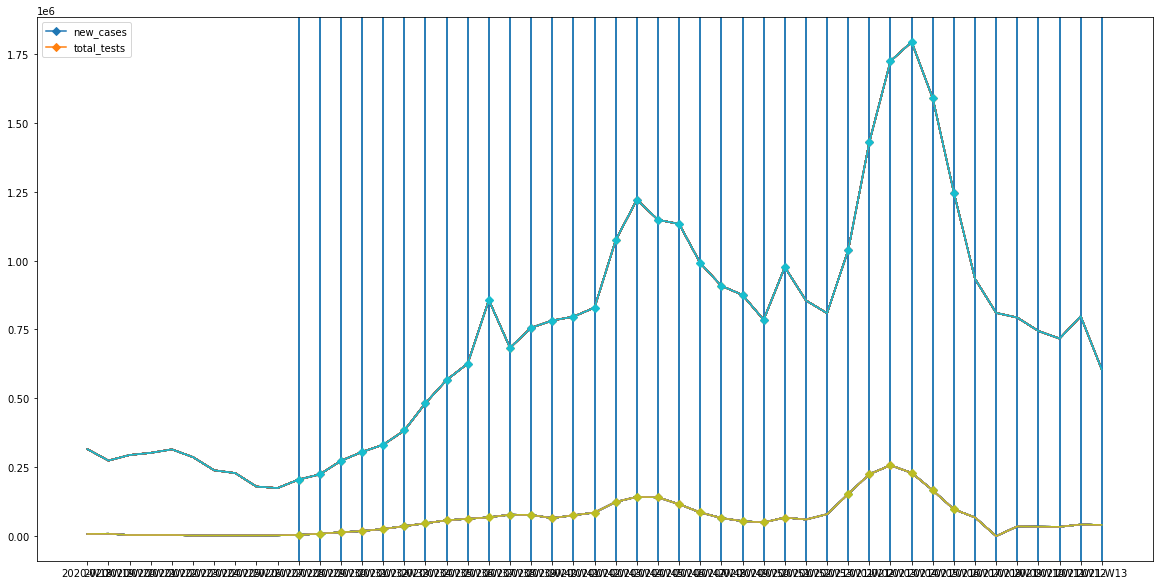

Wall time: 9.87 s


In [69]:
%%time
#fit on past, predict on current week

#split in chuncks of x weeks
chunck_size = 1
chuncks = split_dataframe(working_dataset, chunck_size)
total_indices = []
for index, current in enumerate(chuncks[1:], start=1):
    if index < 10:
#         print(index)
        continue
    until_current = join_dataframe(chuncks[:index])
    clf = alg.fit(until_current)
    pred = clf.predict(current).tolist()
    indices = [num + index * chunck_size for num, element in enumerate(pred) if element == -1]
    total_indices.extend(indices)
    vertical_marks = []
    pyplot.plot(working_dataset, '-D', markevery=indices)
    try:
        start_incides = index * chunck_size
        end_incides = ( index + 1 ) * chunck_size - 1 
        vertical_marks = [working_dataset.iloc[start_incides].name, working_dataset.iloc[end_incides].name]
        pyplot.axvline(x=vertical_marks[0])
        pyplot.axvline(x=vertical_marks[1])
    except:
        pass
#     pyplot.legend(['new_cases', 'total_tests'])
#     pyplot.show()
    
print("overlapped")
print(f"total outliers: {len(total_indices)}")
pyplot.plot(working_dataset, '-D', markevery=total_indices)
pyplot.legend(['new_cases', 'total_tests'])
pyplot.show()


In [72]:
# DEPRECATED
# %%time
# #fit on past, predict on current week with timestamp as input
# from sklearn.ensemble import IsolationForest
# dataset = datasets[dataset_number]
# dataset_no_country = dataset[dataset['country']==country_code].copy().drop('country', axis='columns')
# dataset_with_time = dataset_no_country.copy()
# dataset_with_time['time']= dataset_with_time.index.values
# dataset_with_time['time'] = dataset_with_time['time'].map(to_epoch)
# dataset_with_time_no_deaths = dataset_with_time.copy().drop('deaths', axis='columns')
# dataset_no_country_no_deaths = dataset_no_country.copy().drop('deaths', axis='columns')
# #split in chuncks of x days
# chunck_size = 7
# chuncks = split_dataframe(dataset_with_time_no_deaths, chunck_size)
# total_indices = []
# for index, current in enumerate(chuncks[1:], start=1):
#     until_current = join_dataframe(chuncks[:index])
#     clf = IsolationForest(random_state=0).fit(until_current)
#     pred = clf.predict(current).tolist()
#     indices = [num + index * chunck_size for num, element in enumerate(pred) if element == -1]
#     total_indices.extend(indices)
#     vertical_marks = []
#     pyplot.plot(dataset_no_country_no_deaths, '-D', markevery=indices)
#     try:
#         start_incides = index * chunck_size
#         end_incides = ( index + 1 ) * chunck_size - 1 
#         vertical_marks = [dataset_no_country_no_deaths.iloc[start_incides].name, dataset_no_country_no_deaths.iloc[end_incides].name]
#         pyplot.axvline(x=vertical_marks[0])
#         pyplot.axvline(x=vertical_marks[1])
#     except:
#         pass
#     pyplot.legend(['cases'])
#     pyplot.show()
    
# print("overlapped")
# print(f"total outliers: {len(total_indices)}")
# pyplot.plot(dataset_no_country_no_deaths, '-D', markevery=total_indices)
# pyplot.legend(['cases'])
# pyplot.show()

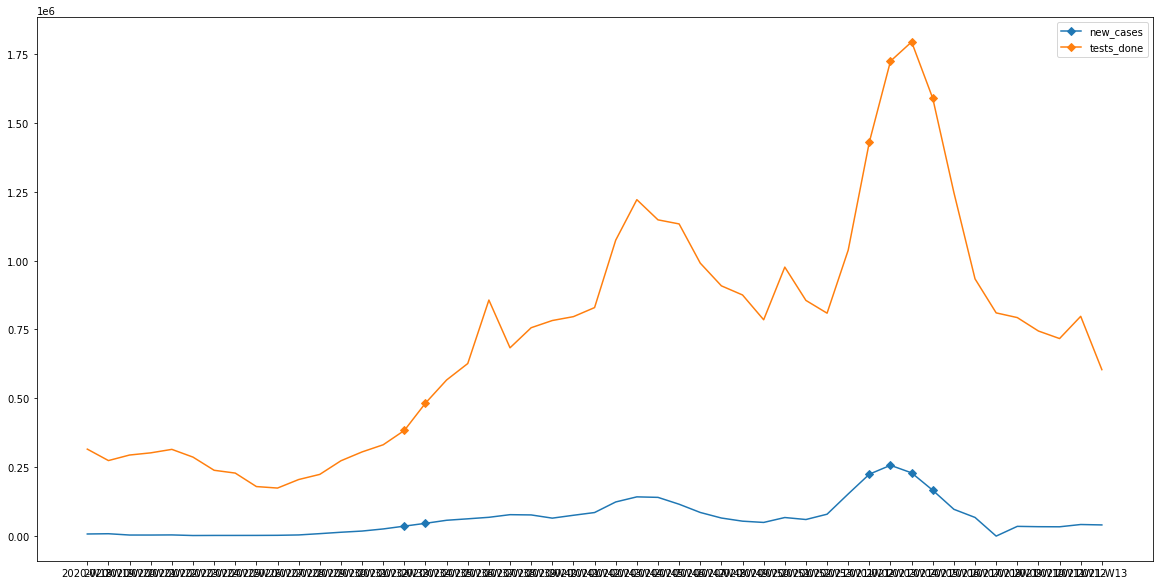

fit on all, predict on all
Number of outliers:
6
Wall time: 599 ms


In [74]:
%%time
#fit on all, predict on all

alg = LocalOutlierFactor(novelty=False, n_neighbors=5)
#clf = alg.fit_predi(working_dataset)
pred = alg.fit_predict(working_dataset)
indices = [index for index, element in enumerate(pred) if element == -1]
pyplot.plot(working_dataset, '-D', markevery=indices)
pyplot.legend(['new_cases', 'tests_done'])
pyplot.show()
print("fit on all, predict on all")
print("Number of outliers:")
print(len(indices))

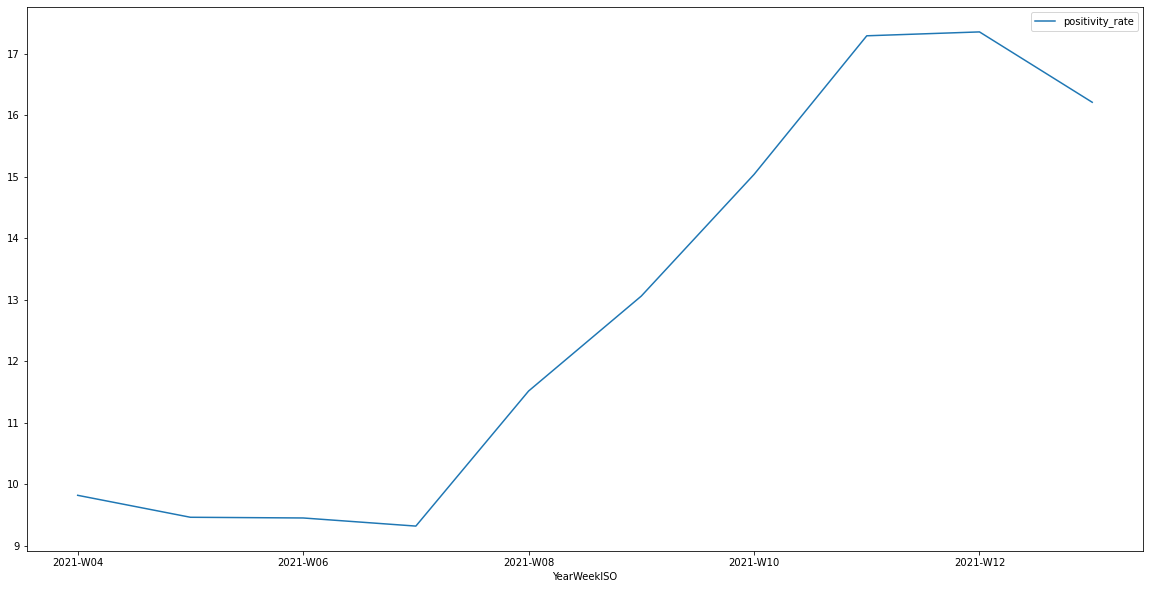

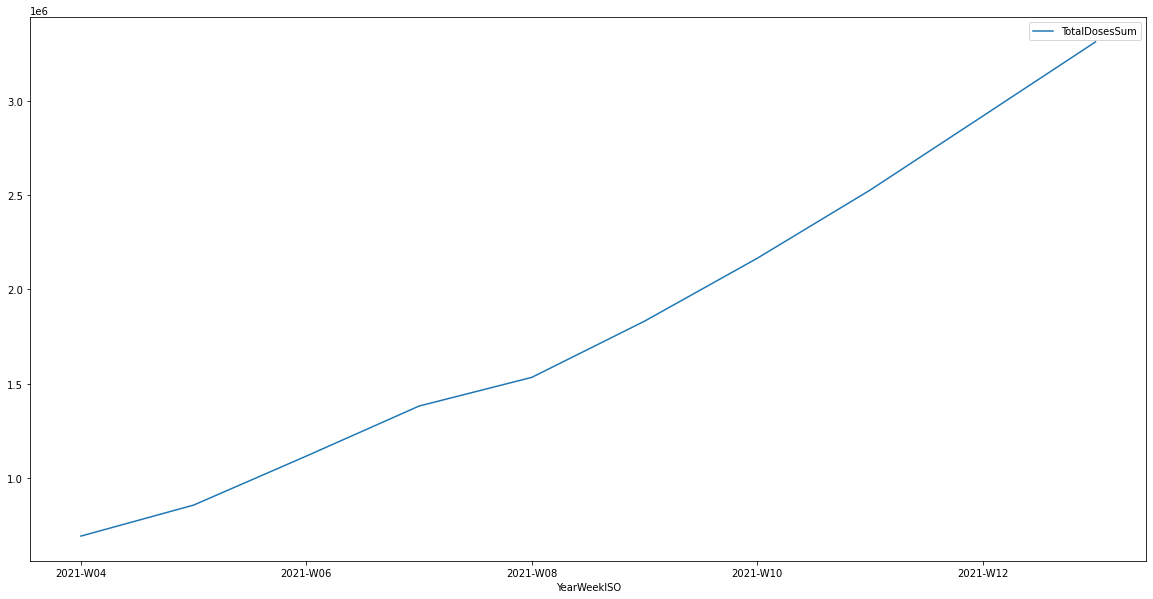

In [14]:
dataset_number = 1
country_code = 'RO'
dataset = datasets[dataset_number]
working_dataset = dataset[dataset['ReportingCountry']==country_code].copy().drop('ReportingCountry', axis='columns')

working_dataset["positivity_rate"].plot()
pyplot.legend(['positivity_rate'])
pyplot.show()

working_dataset["TotalDosesSum"].plot()
pyplot.legend(['TotalDosesSum'])
pyplot.show()

In [15]:
# alg = IsolationForest(random_state=0)
alg = LocalOutlierFactor(novelty=True, n_neighbors=200)
# alg = LocalOutlierFactor(novelty=False, n_neighbors=200)